In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data from csv file
# dataset_url = https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv
shopper_intention_filename = 'online_shoppers_intention.csv'
shopper_intention_data = pd.read_csv(shopper_intention_filename)

In [3]:
X = shopper_intention_data.drop("Revenue", axis = 1)
y = shopper_intention_data["Revenue"]

## Feature Engineering

#### Drop features based on Correlation

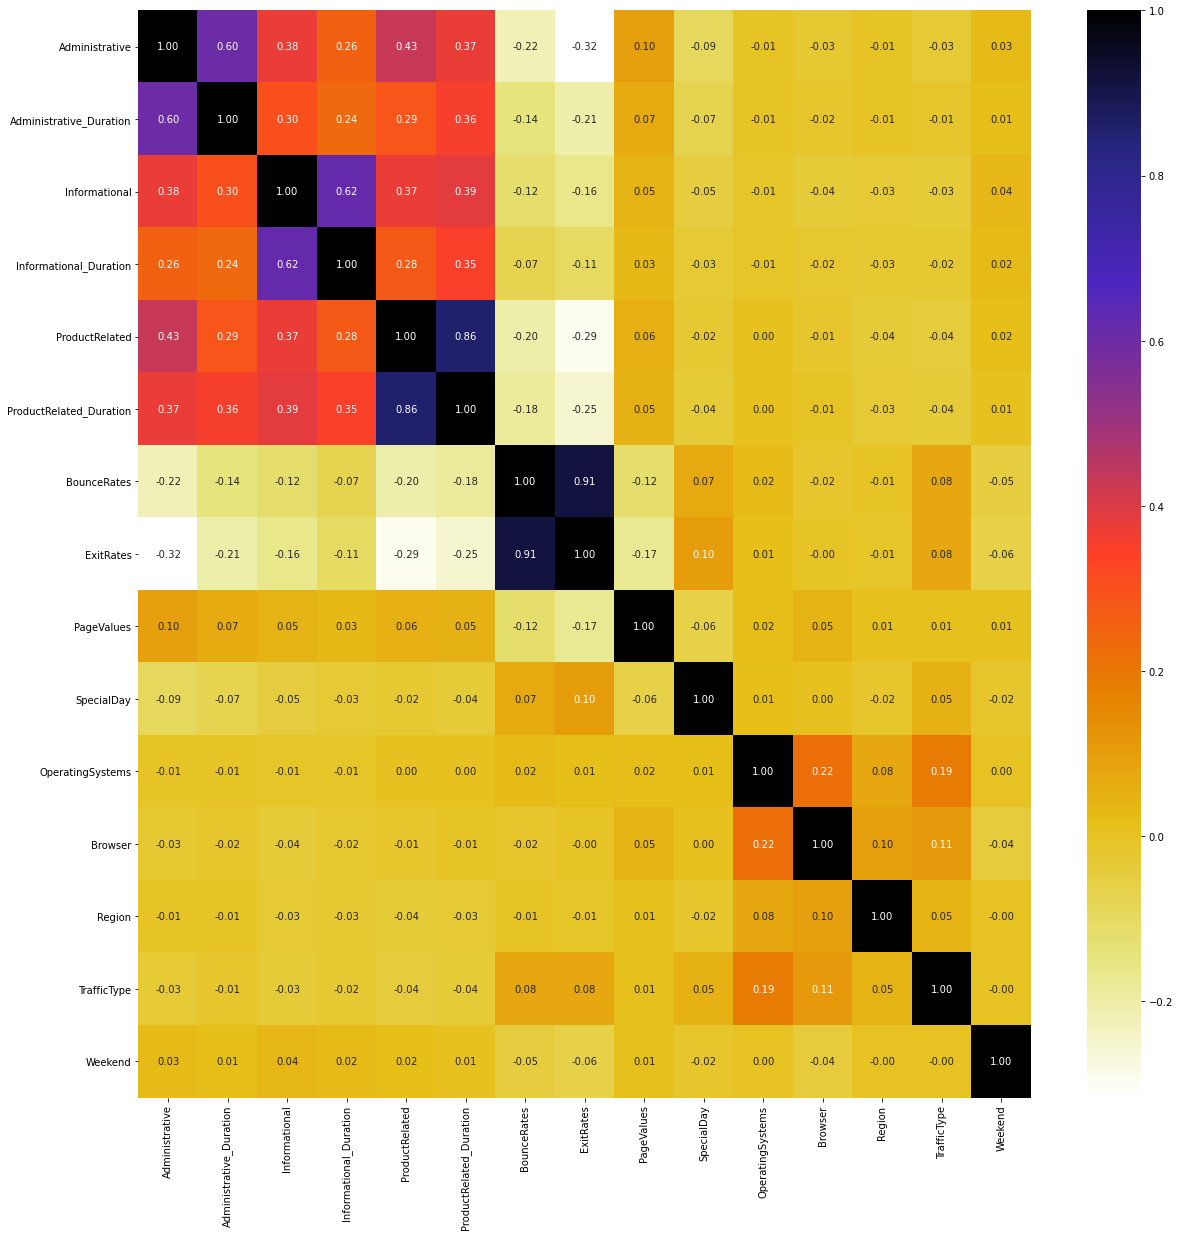

In [4]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = X.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, fmt=".2f")
plt.show()

In [5]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with any other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [6]:
corr_features = correlation(X, 0.55)  # selecting features having correlation > 55% (absolute)
len(set(corr_features))
print("Highly Correlated Features: {}".format(corr_features))

Highly Correlated Features: {'Informational_Duration', 'ProductRelated_Duration', 'Administrative_Duration', 'ExitRates'}


In [7]:
# Drop correlated features
X = X.drop(corr_features,axis=1)
X.shape

(12330, 13)

#### Scaling Numerical features

In [8]:
from sklearn.preprocessing import StandardScaler

scaled_features = X.copy()

col_names = ['Administrative','Informational','ProductRelated','BounceRates',\
             'PageValues','SpecialDay','OperatingSystems','Browser','Region','TrafficType']
features = scaled_features[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

scaled_features[col_names] = features
scaled_features

X['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

#### Transform Categorical features

In [9]:
# Encoding VisitorType,Month Features
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

non_categoricals = ['Administrative','Informational','ProductRelated',\
                    'BounceRates','PageValues','SpecialDay','Month','OperatingSystems',\
                    'Browser','Region','TrafficType']
months = ['Feb','Mar','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
transformer = ColumnTransformer(transformers=[
    ('tnf1', OrdinalEncoder(categories=[months]),['Month']),
    ('tnf2', OneHotEncoder(drop='first', sparse=False),['VisitorType']),
], remainder='passthrough')
X = transformer.fit_transform(scaled_features)

## Over-sampled Dataset: Online Shoppers Intention dataset for best results

In [10]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os =  RandomOverSampler()
X_os, y_os = os.fit_resample(X, y)

y_os = pd.DataFrame(y_os)
print("Class Distribution Before Oversampling: \n", y.value_counts(),"\n")
print("Class Distribution After Oversampling: \n", y_os.value_counts())

Class Distribution Before Oversampling: 
 False    10422
True      1908
Name: Revenue, dtype: int64 

Class Distribution After Oversampling: 
 Revenue
False      10422
True       10422
dtype: int64


### 1.1 CROSS VALIDATION (10 fold)

In [11]:
classifiers = []
names = ['Decision_Tree','Random_Forest','Linear_SVM','Nearest_Neighbors', \
         'Multilayer_Perceptron','Gradient_Boosting']
d1_cv_scores = {}

In [12]:
from sklearn.model_selection import cross_val_score
from statistics import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

oversampled_accuracies = {}

In [13]:
dtc_accuracy = cross_val_score(DecisionTreeClassifier(max_leaf_nodes=8), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1, scoring='accuracy')
oversampled_accuracies["Decision_Tree"] = dtc_accuracy
print("Decision Tree: ", mean(dtc_accuracy))

rfc_accuracy = cross_val_score(RandomForestClassifier(), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
oversampled_accuracies["Random_Forest"] = rfc_accuracy
print("Random Forest: ", mean(rfc_accuracy))

svm_accuracy = cross_val_score(LinearSVC(), \
                                                X_os, y_os, cv=10, verbose=0, n_jobs=-1)
oversampled_accuracies["SVM"] = svm_accuracy
print("Support Vector Machine: ", mean(svm_accuracy))

knn_accuracy = cross_val_score(KNeighborsClassifier(), \
                                                   X_os, y_os, cv=10, verbose=0, n_jobs=-1)
oversampled_accuracies["KNN"] = knn_accuracy
print("K Nearest Neighbor: ", mean(knn_accuracy))



Decision Tree:  0.848103881578039
Random Forest:  0.957251089723231
Support Vector Machine:  0.7939892845800135
K Nearest Neighbor:  0.8690172008266707


In [14]:
# Comparing Mean accuracies before and after tuning
d1_before_tuning = []
for key in oversampled_accuracies.keys():
    d1_before_tuning.append(mean(oversampled_accuracies[key]))
d1_after_tuning = []

### 1.2 Hyper Parameter Optimization

In [15]:
from sklearn.model_selection import GridSearchCV

def getBestParameters(model,params):
    gs = GridSearchCV(estimator=model, param_grid=params, cv=10, verbose=1, n_jobs=-1)
    gs.fit(X_os, y_os)
    return gs

#### 1.2.1 Decision Tree Classifier

In [16]:
dtc = DecisionTreeClassifier()
params = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [5,7,8,9,10,11,12,13,None],
    'random_state': [42]
}

In [17]:
gs = getBestParameters(dtc, params)
gs.best_params_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'random_state': 42,
 'splitter': 'best'}

In [18]:
classifiers.append(DecisionTreeClassifier(**gs.best_params_))
dtc_scores = cross_val_score(DecisionTreeClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Decision Tree (Tuned): ", mean(dtc_scores))
d1_after_tuning.append(mean(dtc_scores))
d1_cv_scores['Decision_Tree'] = dtc_scores

Decision Tree (Tuned):  0.9505803495399457


#### 1.2.2 Random Forest Classifier

In [19]:
rfc = RandomForestClassifier()
params = {
    'criterion': ['gini','entropy'],
    'n_estimators': [5,10,20,30,50,70,100],
    'max_depth': [100,140,170,190,200],
    'max_features':['auto','sqrt','log2'],
    'random_state': [42]
}

In [20]:
gs = getBestParameters(rfc, params)
gs.best_params_

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


{'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'auto',
 'n_estimators': 10,
 'random_state': 42}

In [21]:
classifiers.append(RandomForestClassifier(**gs.best_params_))
rfc_scores = cross_val_score(RandomForestClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Random Forest (Tuned): ", mean(rfc_scores))
d1_after_tuning.append(mean(rfc_scores))
d1_cv_scores['Random_Forest'] = rfc_scores

Random Forest (Tuned):  0.9608494317789531


#### 1.2.3 Support Vector Machine

In [22]:
svm = LinearSVC()
params = {
    'C': [1,100,1000],
    'penalty': ['l1','l2'],
    'loss': ['hinge','squared_hinge'],
    'random_state': [42]
}

In [23]:
gs = getBestParameters(svm, params)
gs.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


{'C': 1, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 42}

In [24]:
classifiers.append(LinearSVC(**gs.best_params_))
svm_scores = cross_val_score(LinearSVC(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Support Vector Machine (Tuned): ", mean(svm_scores))
d1_after_tuning.append(mean(svm_scores))
d1_cv_scores['Linear_SVC'] = svm_scores

Support Vector Machine (Tuned):  0.8235450871548442


#### 1.2.4 K-Nearest Neighbors

In [25]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [1,8,25,49,64,100],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
}

In [26]:
gs = getBestParameters(knn, params)
gs.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'algorithm': 'brute', 'n_neighbors': 1}

In [27]:
classifiers.append(KNeighborsClassifier(**gs.best_params_))
knn_scores = cross_val_score(KNeighborsClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("K-Nearest Neighbors (Tuned): ", mean(knn_scores))
d1_after_tuning.append(mean(knn_scores))
d1_cv_scores['KNN'] = knn_scores

K-Nearest Neighbors (Tuned):  0.9450154425404015


### 2.1 Multi-layer Perceptron Algorithm

In [28]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(3,2), activation='relu')
mlp_scores = cross_val_score(mlp, \
                            X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Multi-layer Perceptron (balanced dataset): ", mean(mlp_scores))
d1_before_tuning.append(mean(mlp_scores))

Multi-layer Perceptron (balanced dataset):  0.8441257588938446


In [29]:
mlp = MLPClassifier()
params = {
    'hidden_layer_sizes': [(10,30,10)],
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

In [30]:
gs = getBestParameters(mlp, params)
gs.best_params_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (10, 30, 10),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [31]:
classifiers.append(MLPClassifier(**gs.best_params_))
mlp_scores = cross_val_score(MLPClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Multi-layer Perceptron (Tuned): ", mean(mlp_scores))
d1_after_tuning.append(mean(mlp_scores))
d1_cv_scores['Multi_Perceptron'] = mlp_scores

Multi-layer Perceptron (Tuned):  0.848918423802225


# 2.2 Gradient Boosting Algorithm

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)

In [33]:
gbc_scores = cross_val_score(gbc, \
                            X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Gradient Boosting Classifier (balanced dataset): ", mean(gbc_scores))
d1_before_tuning.append(mean(gbc_scores))

Gradient Boosting Classifier (balanced dataset):  0.8586606875727825


In [34]:
gbc = GradientBoostingClassifier()
params = {
    'n_estimators': [12,15,17,20],
    "learning_rate":[0.01,0.1,1,10,100],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse','squared_error','mse'],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [42]
}

In [35]:
gs = getBestParameters(gbc, params)
gs.best_params_

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


{'criterion': 'friedman_mse',
 'learning_rate': 1,
 'loss': 'deviance',
 'max_features': 'auto',
 'n_estimators': 20,
 'random_state': 42}

In [36]:
classifiers.append(GradientBoostingClassifier(**gs.best_params_))
gbc_scores = cross_val_score(GradientBoostingClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Gradient Boosting Classifier (Tuned): ", mean(gbc_scores))
d1_after_tuning.append(mean(gbc_scores))
d1_cv_scores['Gradient_Boosting'] = gbc_scores

Gradient Boosting Classifier (Tuned):  0.8599541556773774


In [37]:
# Comparing Mean accuracies before and after tuning
# Dataset-1 accuracies before tuning
d1_before_tuning

[0.848103881578039,
 0.957251089723231,
 0.7939892845800135,
 0.8690172008266707,
 0.8441257588938446,
 0.8586606875727825]

In [38]:
# Dataset-1 accuracies after tuning
d1_after_tuning

[0.9505803495399457,
 0.9608494317789531,
 0.8235450871548442,
 0.9450154425404015,
 0.848918423802225,
 0.8599541556773774]

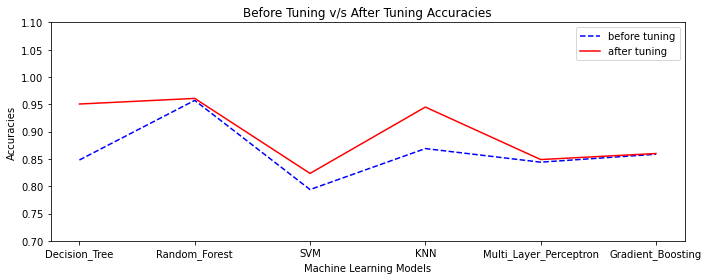

<Figure size 720x288 with 0 Axes>

In [39]:
# Plotting changes in accuracies of 6 algorithms implemented on dataset-1
# Online Shopper's Intention Dataset
q1_models = ['Decision_Tree','Random_Forest','SVM','KNN','Multi_Layer_Perceptron','Gradient_Boosting']
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True
plt.plot(q1_models, d1_before_tuning, '--b', label='before tuning')
plt.plot(q1_models, d1_after_tuning, '-r', label='after tuning')
plt.title('Before Tuning v/s After Tuning Accuracies')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracies')
plt.legend()
plt.ylim([0.700,1.100])
spacing=0.500
plt.show()

plt.savefig('dataset-1-before_and_after_tuning_q2.png')

# 3. Statistical Significance (alpha = 0.05)

#### table showing the accuracies of the six algorithms against each one (1) of the ten (10) folds

In [40]:
from tabulate import tabulate

scores_df = pd.DataFrame(d1_cv_scores)
# display(scores_df)
scores_df = scores_df.round(3)
scores_df.loc['mean'] = scores_df.mean()
print(tabulate(scores_df, headers = 'keys', tablefmt = 'grid'))

+------+-----------------+-----------------+--------------+--------+--------------------+---------------------+
|      |   Decision_Tree |   Random_Forest |   Linear_SVC |    KNN |   Multi_Perceptron |   Gradient_Boosting |
+======+=================+=================+==============+========+====================+=====================+
| 0    |          0.984  |          0.981  |       0.879  | 0.968  |             0.933  |              0.925  |
+------+-----------------+-----------------+--------------+--------+--------------------+---------------------+
| 1    |          0.972  |          0.968  |       0.794  | 0.962  |             0.863  |              0.868  |
+------+-----------------+-----------------+--------------+--------+--------------------+---------------------+
| 2    |          0.982  |          0.979  |       0.833  | 0.98   |             0.882  |              0.883  |
+------+-----------------+-----------------+--------------+--------+--------------------+---------------

#### calculate statistical significant difference between algorithm accuracies
#### T-test

#### Null Hypothesis: There is NO significant statistical difference between accuracies of 6 algorithms.
#### Alternate Hypothesis: There is significant statistical difference between accuracies of 6 algorithms.
#### ttest_rel

In [41]:

p_value_results = {
    "Comparing_Algorithms": [],
    "Calculated_P_Value": [],
    "Null_Hypothesis": [],
    "Result": []
}

null_hypothesis_status = ["Reject Null Hypothesis", "Accept Null Hypothesis"]
result_statement = ["There exists a significant difference in accuracies of these algorithms.", \
               "There is NO significant difference in accuracies of these algorithms."]

#### Method to calculate p_value and accept/reject Null hypothesis

In [42]:
def has_Statistical_Difference(model_1, model_2, scores_1, scores_2):
    _,p_value = ttest_rel(scores_1, scores_2)
    model_comparison = model_1 +" & "+ model_2
    p_value_results["Comparing_Algorithms"].append(model_comparison)
    print("\n\nP-Value for comparison {} and {} : {p_value:.9f}".format(model_1, model_2, p_value=p_value))
    p_value_results["Calculated_P_Value"].append(p_value)
    if p_value < 0.05: # since alpha value is 0.05
        print("REJECTING Null Hypothesis \
                \nThere is significant difference in accuracy of {} and {}".format(model_1, model_2))
        p_value_results["Null_Hypothesis"].append(null_hypothesis_status[0])
        p_value_results["Result"].append(result_statement[0])
    else:
        print("ACCEPTING Null Hypothesis \
                \nThere is NO significant difference in accuracy of {} and {}".format(model_1, model_2))
        p_value_results["Null_Hypothesis"].append(null_hypothesis_status[1])
        p_value_results["Result"].append(result_statement[1])

### Perform Paired T-test on all possible combinations of implemented algorithms for dataset 1

In [43]:
from itertools import combinations

ttest_pair_list = list(combinations(d1_cv_scores.keys(), 2))

In [44]:
from scipy.stats import ttest_rel

for ttest_pair in ttest_pair_list:
    # print(ttest_pair)
    first_model = ttest_pair[0]
    second_model = ttest_pair[1]
    has_Statistical_Difference(first_model, second_model, d1_cv_scores[first_model], d1_cv_scores[second_model])



P-Value for comparison Decision_Tree and Random_Forest : 0.024582087
REJECTING Null Hypothesis                 
There is significant difference in accuracy of Decision_Tree and Random_Forest


P-Value for comparison Decision_Tree and Linear_SVC : 0.000000076
REJECTING Null Hypothesis                 
There is significant difference in accuracy of Decision_Tree and Linear_SVC


P-Value for comparison Decision_Tree and KNN : 0.014544535
REJECTING Null Hypothesis                 
There is significant difference in accuracy of Decision_Tree and KNN


P-Value for comparison Decision_Tree and Multi_Perceptron : 0.000001749
REJECTING Null Hypothesis                 
There is significant difference in accuracy of Decision_Tree and Multi_Perceptron


P-Value for comparison Decision_Tree and Gradient_Boosting : 0.000000037
REJECTING Null Hypothesis                 
There is significant difference in accuracy of Decision_Tree and Gradient_Boosting


P-Value for comparison Random_Forest and Line

##### Print calculated p_values data frame as table

In [45]:

p_value_results_df = pd.DataFrame(p_value_results)
# display(scores_df)
p_value_results_df = p_value_results_df.round(9)



##### Export dataframe as a png image in table format

In [46]:
# dfi.export(p_value_results_df, 'p_values_dataframe.png')

# 4. Applying Algorithms to datasets 

### 4.1 Customer Personality Analysis Dataset
### Classify whether it is a Teenhome or Not.

In [47]:
# read data from csv file
file_path = 'marketing_campaign.csv'
df = pd.read_csv(file_path, sep='\t')
df.shape

(2240, 29)

In [48]:
# Information about features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [49]:
# Some null values are present for Income column ,dropping those rows.
df = df.dropna()
df.shape

(2216, 29)

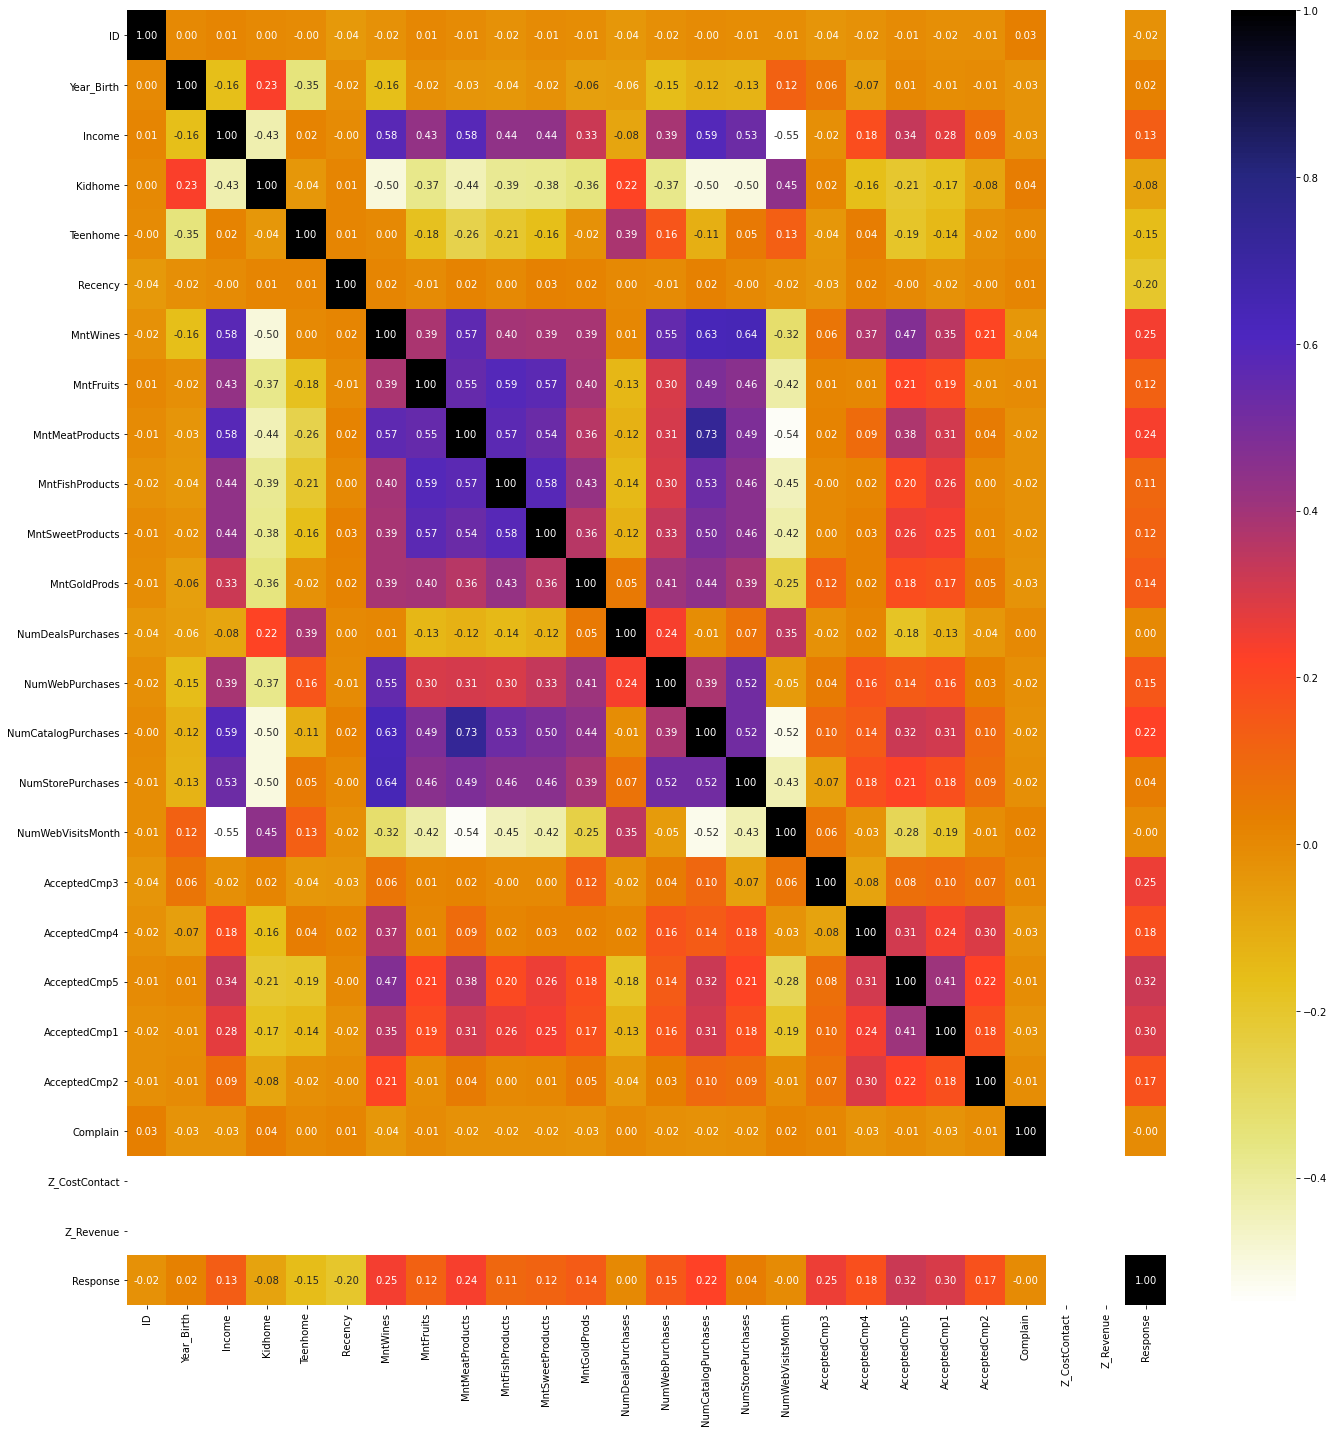

In [50]:
# Let's look at correlation matrix
import seaborn as sns

plt.figure(figsize=(20,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, fmt=".2f")
plt.show()

In [51]:
# Correlation of features with target
cor_target = abs(cor[["Teenhome"]])

In [52]:
cor_target

,Teenhome
ID,0.003030
Year_Birth,0.350791
Income,0.019133
Kidhome,0.039869
Teenhome,1.000000
Recency,0.013838
MntWines,0.003747
MntFruits,0.176558
MntMeatProducts,0.261122
MntFishProducts,0.205242


In [53]:
# drop features having correlation of less than 5% with target
features_to_drop = ["ID","Kidhome","Recency","MntWines","MntGoldProds","NumStorePurchases",\
                    "AcceptedCmp3","AcceptedCmp4","AcceptedCmp2","Complain","Z_CostContact",\
                    "Z_Revenue","Response"]
df = df.drop(features_to_drop, axis=1)

In [54]:
# analysing correlation between features
corr_features = correlation(df, 0.55)  # selecting features having correlation > 55% (absolute)
len(set(corr_features))
print("Highly Correlated Features: {}".format(corr_features))
df.drop(corr_features, axis=1).shape

Highly Correlated Features: {'MntFishProducts', 'MntMeatProducts', 'MntSweetProducts', 'NumCatalogPurchases', 'NumWebVisitsMonth'}


(2216, 11)

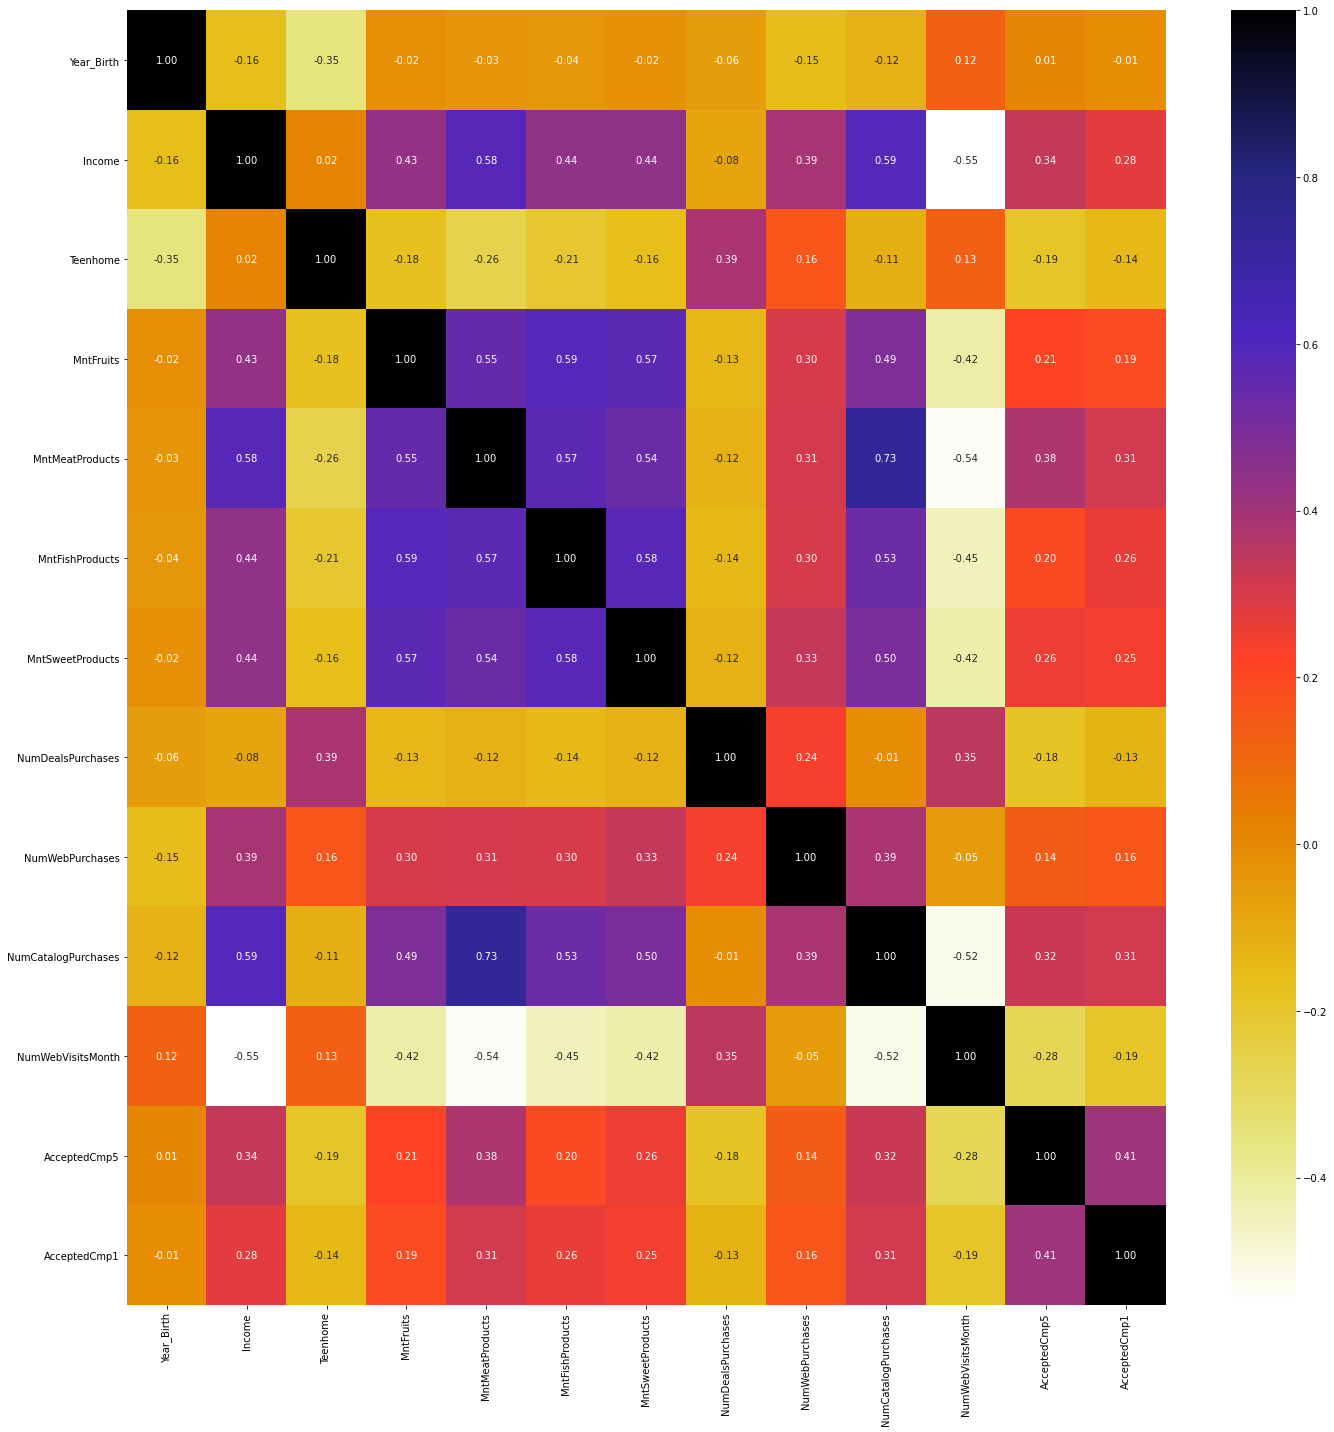

In [55]:
plt.figure(figsize=(20,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, fmt=".2f")
plt.show()

In [56]:
# Check number of unique target labels
df["Teenhome"].value_counts()

0    1147
1    1018
2      51
Name: Teenhome, dtype: int64

In [57]:
df["Teenhome"] = df["Teenhome"].replace({0: False, 1:True, 2:True})

In [58]:
# Age can be extracted from Year_Birth feature
df["Age"] = 2021 - df["Year_Birth"]
df = df.drop("Year_Birth", axis=1)
df

,Education,Marital_Status,Income,Teenhome,Dt_Customer,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp5,AcceptedCmp1,Age
0,Graduation,Single,58138.0,False,04-09-2012,88,546,172,88,3,8,10,7,0,0,64
1,Graduation,Single,46344.0,True,08-03-2014,1,6,2,1,2,1,1,5,0,0,67
2,Graduation,Together,71613.0,False,21-08-2013,49,127,111,21,1,8,2,4,0,0,56
3,Graduation,Together,26646.0,False,10-02-2014,4,20,10,3,2,2,0,6,0,0,37
4,PhD,Married,58293.0,False,19-01-2014,43,118,46,27,5,5,3,5,0,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Married,61223.0,True,13-06-2013,43,182,42,118,2,9,3,5,0,0,54
2236,PhD,Together,64014.0,True,10-06-2014,0,30,0,0,7,8,2,7,0,1,75
2237,Graduation,Divorced,56981.0,False,25-01-2014,48,217,32,12,1,2,3,6,0,0,40
2238,Master,Together,69245.0,True,24-01-2014,30,214,80,30,2,6,5,3,0,0,65


In [59]:
df["Age"].describe()

count    2216.000000
mean       52.179603
std        11.985554
min        25.000000
25%        44.000000
50%        51.000000
75%        62.000000
max       128.000000
Name: Age, dtype: float64

In [60]:
# filter dataset according to age values and drop rows with unrealistic values
df = df[ (df['Age'] < 100) ]

In [61]:
# Seggregate dependent and independent feature(s)
X = df.drop("Teenhome", axis=1)
y = df["Teenhome"]

Teenhome-True: (1068, 16)
Teenhome-False: (1145, 16)


Text(0, 0.5, 'Frequency')

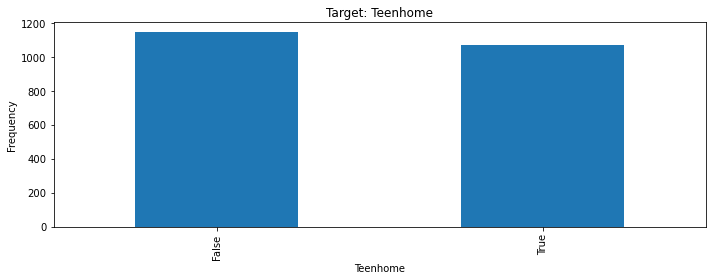

In [62]:
# Dataset is BALANCED, with respect to target.
count_classes = pd.value_counts(df['Teenhome'], sort = True)
teenhome_true = df[df['Teenhome'] == True]
teenhome_false = df[df['Teenhome'] == False]
print('Teenhome-True: {}\nTeenhome-False: {}'.format(teenhome_true.shape , teenhome_false.shape))
count_classes.plot(kind = 'bar')
plt.title("Target: Teenhome")
plt.xlabel("Teenhome")
plt.ylabel("Frequency")

In [63]:
X.head()

,Education,Marital_Status,Income,Dt_Customer,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp5,AcceptedCmp1,Age
0,Graduation,Single,58138.0,04-09-2012,88,546,172,88,3,8,10,7,0,0,64
1,Graduation,Single,46344.0,08-03-2014,1,6,2,1,2,1,1,5,0,0,67
2,Graduation,Together,71613.0,21-08-2013,49,127,111,21,1,8,2,4,0,0,56
3,Graduation,Together,26646.0,10-02-2014,4,20,10,3,2,2,0,6,0,0,37
4,PhD,Married,58293.0,19-01-2014,43,118,46,27,5,5,3,5,0,0,40


In [64]:
# 'Education' feature can be reduced to lesser labels and encoded further
X["Education"].value_counts()

Graduation    1116
PhD            480
Master         365
2n Cycle       198
Basic           54
Name: Education, dtype: int64

In [65]:
X["Education"] = X["Education"].replace(
    {
        "Basic":"Undergrad","2n Cycle":"Undergrad", \
        "Graduation":"Grad", "Master":"Grad", \
        "PhD":"PostGrad"
    })

In [66]:
X["Education"].value_counts()

Grad         1481
PostGrad      480
Undergrad     252
Name: Education, dtype: int64

In [67]:
# Number of labels for 'Marital_Status' can also be reduced
# and eventually encoded to binary values
X["Marital_Status"].value_counts()

X["Lives_Alone"] = X["Marital_Status"].replace(
    {
        "Married":0, "Together":0, "Single":1, \
        "Divorced":1, "Widow":1, "Alone":1, "YOLO":1, \
        "Absurd":1
    })

In [68]:
X = X.drop("Marital_Status", axis=1)
X

,Education,Income,Dt_Customer,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp5,AcceptedCmp1,Age,Lives_Alone
0,Grad,58138.0,04-09-2012,88,546,172,88,3,8,10,7,0,0,64,1
1,Grad,46344.0,08-03-2014,1,6,2,1,2,1,1,5,0,0,67,1
2,Grad,71613.0,21-08-2013,49,127,111,21,1,8,2,4,0,0,56,0
3,Grad,26646.0,10-02-2014,4,20,10,3,2,2,0,6,0,0,37,0
4,PostGrad,58293.0,19-01-2014,43,118,46,27,5,5,3,5,0,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Grad,61223.0,13-06-2013,43,182,42,118,2,9,3,5,0,0,54,0
2236,PostGrad,64014.0,10-06-2014,0,30,0,0,7,8,2,7,0,1,75,0
2237,Grad,56981.0,25-01-2014,48,217,32,12,1,2,3,6,0,0,40,1
2238,Grad,69245.0,24-01-2014,30,214,80,30,2,6,5,3,0,0,65,0


In [69]:
# not relevant for current use-case
X = X.drop("Dt_Customer", axis=1)

In [70]:
# All Expenses/Spendings can be combined together to form a new feature
X["total_expenses"] = X["MntFruits"] + X["MntMeatProducts"] + \
                      X["MntFishProducts"] + X["MntSweetProducts"]
X = X.drop(["MntFruits","MntMeatProducts", \
              "MntFishProducts","MntSweetProducts"], axis=1)
X

,Education,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp5,AcceptedCmp1,Age,Lives_Alone,total_expenses
0,Grad,58138.0,3,8,10,7,0,0,64,1,894
1,Grad,46344.0,2,1,1,5,0,0,67,1,10
2,Grad,71613.0,1,8,2,4,0,0,56,0,308
3,Grad,26646.0,2,2,0,6,0,0,37,0,37
4,PostGrad,58293.0,5,5,3,5,0,0,40,0,234
...,...,...,...,...,...,...,...,...,...,...,...
2235,Grad,61223.0,2,9,3,5,0,0,54,0,385
2236,PostGrad,64014.0,7,8,2,7,0,1,75,0,30
2237,Grad,56981.0,1,2,3,6,0,0,40,1,309
2238,Grad,69245.0,2,6,5,3,0,0,65,0,354


In [71]:
X["AcceptedCmp5"].value_counts()

0    2052
1     161
Name: AcceptedCmp5, dtype: int64

In [72]:
X["AcceptedCmp1"].value_counts()

0    2071
1     142
Name: AcceptedCmp1, dtype: int64

In [73]:
# Label encoding for 'Education' Feature
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X["Education"]=X[["Education"]].apply(le.fit_transform)

In [74]:
# Scaling all features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaled_X = pd.DataFrame(scaler.transform(X),columns= X.columns )
scaled_X

,Education,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp5,AcceptedCmp1,Age,Lives_Alone,total_expenses
0,-0.645376,0.234435,0.350656,1.427316,2.504247,0.692198,-0.280107,-0.261851,1.018785,1.350076,2.039679
1,-0.645376,-0.234084,-0.169104,-1.126455,-0.571168,-0.132699,-0.280107,-0.261851,1.275248,1.350076,-0.795153
2,-0.645376,0.769733,-0.688863,1.427316,-0.229456,-0.545148,-0.280107,-0.261851,0.334882,-0.740699,0.160480
3,-0.645376,-1.016592,-0.169104,-0.761631,-0.912881,0.279749,-0.280107,-0.261851,-1.289387,-0.740699,-0.708569
4,0.806064,0.240593,1.390175,0.332842,0.112257,-0.132699,-0.280107,-0.261851,-1.032923,-0.740699,-0.076825
...,...,...,...,...,...,...,...,...,...,...,...
2208,-0.645376,0.356988,-0.169104,1.792140,0.112257,-0.132699,-0.280107,-0.261851,0.163906,-0.740699,0.407406
2209,0.806064,0.467861,2.429694,1.427316,-0.229456,0.692198,-0.280107,3.818967,1.959151,-0.740699,-0.731017
2210,-0.645376,0.188473,-0.688863,-0.761631,0.112257,0.279749,-0.280107,-0.261851,-1.032923,1.350076,0.163687
2211,-0.645376,0.675663,-0.169104,0.697667,0.795683,-0.957597,-0.280107,-0.261851,1.104272,-0.740699,0.307994


In [75]:
scaled_X.shape

(2213, 11)

### Model training

In [76]:
from sklearn.model_selection import cross_val_score
from statistics import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

d2_cv_scores = {}

In [77]:
print("Decision Tree: ", mean(cross_val_score(DecisionTreeClassifier(), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)))
print("Random Forest: ", mean(cross_val_score(RandomForestClassifier(), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)))
print("Support Vector Machine: ", mean(cross_val_score(LinearSVC(), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)))
print("K Nearest Neighbor: ", mean(cross_val_score(KNeighborsClassifier(), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)))
print("Multi-layer Perceptron: ", mean(cross_val_score(MLPClassifier(), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)))
print("Gradient Boosting Classifier: ", mean(cross_val_score(GradientBoostingClassifier(), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)))

Decision Tree:  0.8540438628673923
Random Forest:  0.8924299865476336
Support Vector Machine:  0.8161081896376015
K Nearest Neighbor:  0.8377603848192083
Multi-layer Perceptron:  0.8820533202886144
Gradient Boosting Classifier:  0.8897211691329339


### Hyper-parameter tuning for all algorithms

In [78]:
dtc = DecisionTreeClassifier()
params = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [5,7,8,9,10,11,12,13,None],
    'random_state': [42]
}

In [79]:
gs = getBestParameters(dtc, params)
gs.best_params_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'random_state': 42,
 'splitter': 'best'}

In [80]:
dtc_scores = cross_val_score(DecisionTreeClassifier(**gs.best_params_), \
                                              scaled_X, y, cv=10, verbose=0, n_jobs=-1)
print("Decision Tree (Tuned): ", mean(dtc_scores))
d2_cv_scores['Decision_Tree'] = dtc_scores

Decision Tree (Tuned):  0.856275732746321


In [81]:
rfc = RandomForestClassifier()
params = {
    'criterion': ['gini','entropy'],
    'n_estimators': [5,10,20,30,50,70,100],
    'max_depth': [100,140,170,190,200],
    'max_features':['auto','sqrt','log2'],
    'random_state': [42]
}

In [82]:
gs = getBestParameters(rfc, params)
gs.best_params_

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


{'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'auto',
 'n_estimators': 10,
 'random_state': 42}

In [83]:
rfc_scores = cross_val_score(RandomForestClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Random Forest (Tuned): ", mean(rfc_scores))
d2_cv_scores['Random_Forest'] = rfc_scores

Random Forest (Tuned):  0.9608494317789531


In [84]:
svm = LinearSVC()
params = {
    'C': [0.1,1,10,50,100,1000],
    'penalty': ['l1','l2'],
    'loss': ['hinge','squared_hinge'],
    'random_state': [42]
}

In [85]:
gs = getBestParameters(svm, params)
gs.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'C': 1, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 42}

In [86]:
svm_scores = cross_val_score(LinearSVC(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Support Vector Machine (Tuned): ", mean(svm_scores))
d2_cv_scores['Linear_SVC'] = svm_scores

Support Vector Machine (Tuned):  0.8235450871548442


In [87]:
knn = KNeighborsClassifier()
params = {'weights':['uniform', 'distance'], 
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
          'p':[1, 2], 
          'metric': ['minkowski', 'manhattan', 'euclidean']
          }

In [88]:
gs = getBestParameters(knn, params)
gs.best_params_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


{'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'weights': 'distance'}

In [89]:
knn_scores = cross_val_score(KNeighborsClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("K-Nearest Neighbors (Tuned): ", mean(knn_scores))
d2_cv_scores['KNN'] = knn_scores

K-Nearest Neighbors (Tuned):  0.8985216816949512


In [90]:
mlp = MLPClassifier()
params = {
    'activation': ['relu','tanh'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}

In [91]:
gs = getBestParameters(mlp, params)
gs.best_params_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


{'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}

In [92]:
classifiers.append(MLPClassifier(**gs.best_params_))
mlp_scores = cross_val_score(MLPClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Multi-layer Perceptron (Tuned): ", mean(mlp_scores))
d2_cv_scores['Multi_Perceptron'] = mlp_scores

Multi-layer Perceptron (Tuned):  0.8672926303870532


In [93]:
gbc = GradientBoostingClassifier()
params = {
    "learning_rate":[0.01,0.1,1,10,100],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse','squared_error','mse'],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [42]
}

In [94]:
gs = getBestParameters(gbc, params)
gs.best_params_

Fitting 10 folds for each of 90 candidates, totalling 900 fits


{'criterion': 'friedman_mse',
 'learning_rate': 1,
 'loss': 'deviance',
 'max_features': 'auto',
 'random_state': 42}

In [95]:
gbc_scores = cross_val_score(GradientBoostingClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Gradient Boosting Classifier (Tuned): ", mean(gbc_scores))
d2_cv_scores['Gradient_Boosting'] = gbc_scores

Gradient Boosting Classifier (Tuned):  0.8939207022098252


### 4.2 Heart Disease Dataset

In [96]:
filename = 'heart.csv'
df = pd.read_csv(filename)
df1 = df.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


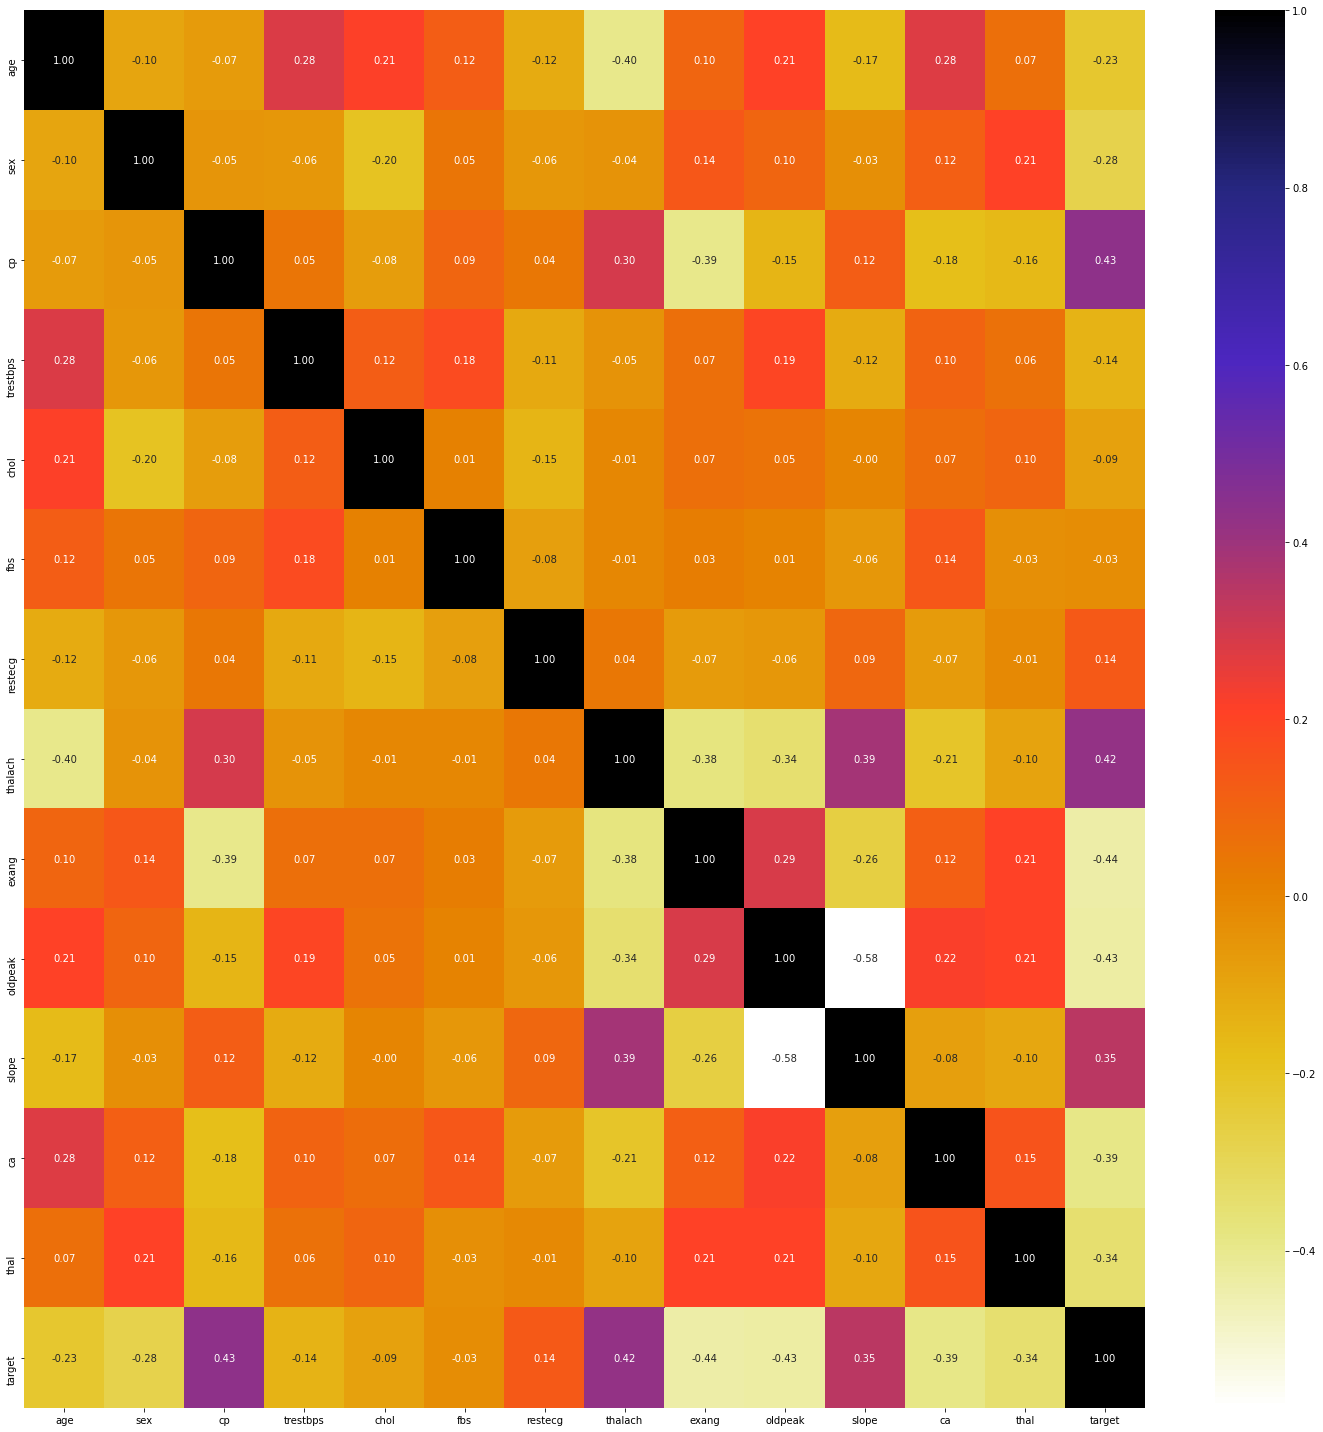

In [97]:
# correlation of features
plt.figure(figsize=(20,20))
cor = df1.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, fmt=".2f")
plt.show()

In [98]:
# Correlation of all features with target
cor_target = abs(cor[["target"]])

In [99]:
cor_target

,target
age,0.225439
sex,0.280937
cp,0.433798
trestbps,0.144931
chol,0.085239
fbs,0.028046
restecg,0.137230
thalach,0.421741
exang,0.436757
oldpeak,0.430696


In [100]:
df1 = df1.drop(["chol", "fbs", "restecg", "trestbps", "sex"], axis=1)

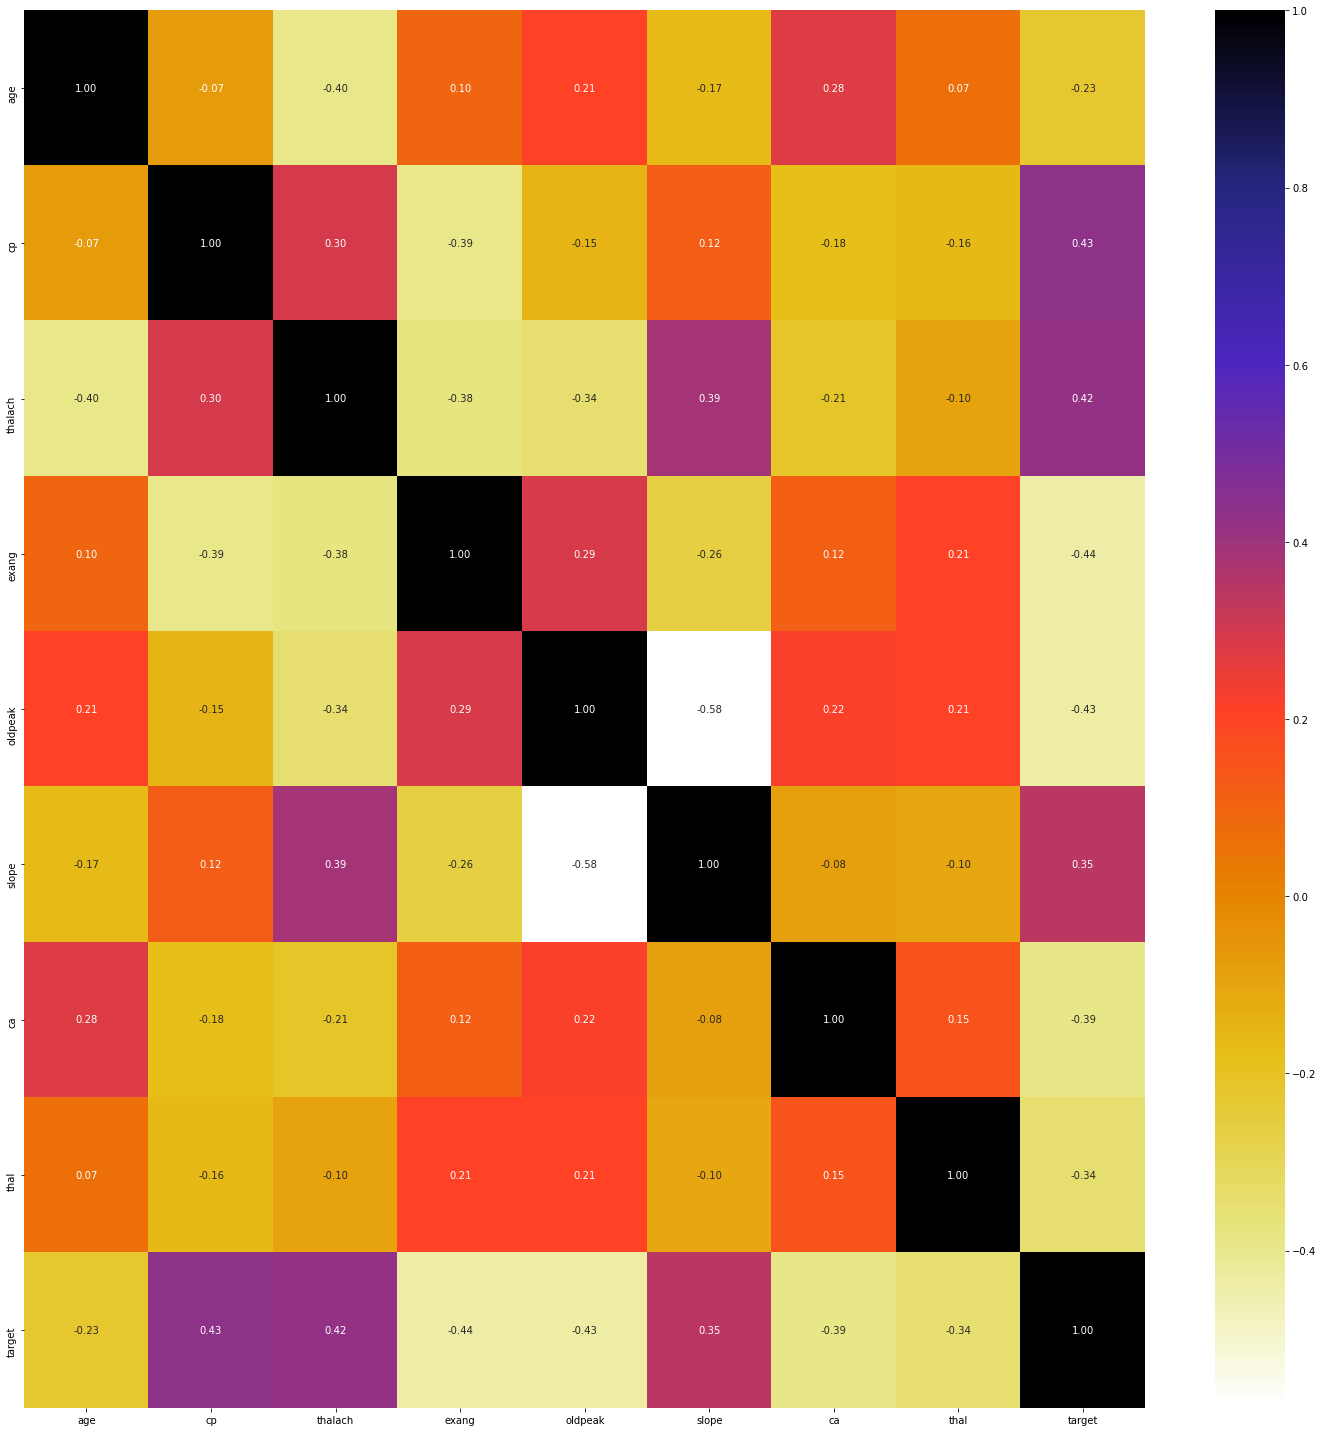

In [101]:
# Let's look at correlation matrix
import seaborn as sns

plt.figure(figsize=(20,20))
cor = df1.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, fmt=".2f")
plt.show()

# No highly correlated features found

In [102]:
# Seggregate features and target
X = df1.drop("target", axis=1)
y = df1["target"]

In [103]:
df1.duplicated().sum()
# repetitive/duplicate record found

1

In [104]:
# drop duplicate record
df1.drop_duplicates(inplace=True)

In [105]:
# Target distribution is balanced
y.value_counts()

1    165
0    138
Name: target, dtype: int64

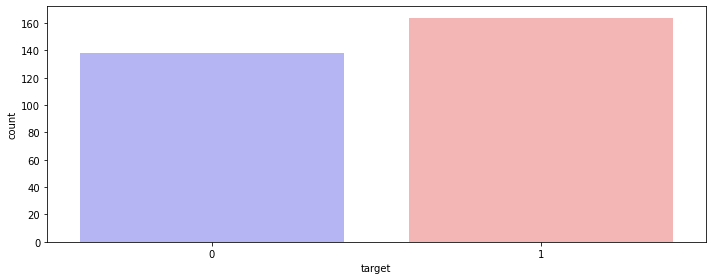

In [106]:
sns.countplot(x="target", data=df1, palette="bwr")
plt.show()

In [107]:
# Scaling all features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaled_features = pd.DataFrame(scaler.transform(X),columns= X.columns )
scaled_features

,age,cp,thalach,exang,oldpeak,slope,ca,thal
0,0.952197,1.973123,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873
1,-1.915313,1.002577,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922
2,-1.474158,0.032031,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922
3,0.180175,0.032031,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922
4,0.290464,-0.938515,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922
...,...,...,...,...,...,...,...,...
298,0.290464,-0.938515,-1.165281,1.435481,-0.724323,-0.649113,-0.714429,1.123029
299,-1.033002,1.973123,-0.771706,-0.696631,0.138373,-0.649113,-0.714429,1.123029
300,1.503641,-0.938515,-0.378132,-0.696631,2.036303,-0.649113,1.244593,1.123029
301,0.290464,-0.938515,-1.515125,1.435481,0.138373,-0.649113,0.265082,1.123029


#### Training Models

In [108]:
from sklearn.model_selection import cross_val_score
from statistics import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

d3_cv_scores = {}

In [109]:
print("Decision Tree: ", mean(cross_val_score(DecisionTreeClassifier(), \
                                              scaled_features, y, cv=10, verbose=0, n_jobs=-1)))
print("Random Forest: ", mean(cross_val_score(RandomForestClassifier(), \
                                              scaled_features, y, cv=10, verbose=0, n_jobs=-1)))
print("Support Vector Machine: ", mean(cross_val_score(LinearSVC(), \
                                                       scaled_features, y, cv=10, verbose=0, n_jobs=-1)))
print("K Nearest Neighbor: ", mean(cross_val_score(KNeighborsClassifier(), \
                                                   scaled_features, y, cv=10, verbose=0, n_jobs=-1)))
print("Multi-layer Perceptron: ", mean(cross_val_score(MLPClassifier(), \
                                              scaled_features, y, cv=10, verbose=0, n_jobs=-1)))
print("Gradient Boosting Classifier: ", mean(cross_val_score(GradientBoostingClassifier(), \
                                              scaled_features, y, cv=10, verbose=0, n_jobs=-1)))

Decision Tree:  0.7091397849462365
Random Forest:  0.8313978494623656
Support Vector Machine:  0.8280645161290323
K Nearest Neighbor:  0.8119354838709678
Multi-layer Perceptron:  0.8512903225806452
Gradient Boosting Classifier:  0.8048387096774193


##### Hyper-paramter tuning 

In [110]:
dtc = DecisionTreeClassifier()
params = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [5,7,8,9,10,11,12,13,None],
    'random_state': [42]
}

In [111]:
gs = getBestParameters(dtc, params)
gs.best_params_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'random_state': 42,
 'splitter': 'best'}

In [112]:
dtc_scores = cross_val_score(DecisionTreeClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Decision Tree (Tuned): ", mean(dtc_scores))
d3_cv_scores['Decision_Tree'] = dtc_scores

Decision Tree (Tuned):  0.9505803495399457


In [113]:
rfc = RandomForestClassifier()
params = {
    'criterion': ['gini','entropy'],
    'n_estimators': [5,10,20,30,50,70,100],
    'max_depth': [100,140,170,190,200],
    'max_features':['auto','sqrt','log2'],
    'random_state': [42]
}

In [114]:
gs = getBestParameters(rfc, params)
gs.best_params_

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


{'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'auto',
 'n_estimators': 10,
 'random_state': 42}

In [115]:
rfc_scores = cross_val_score(RandomForestClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Random Forest (Tuned): ", mean(rfc_scores))
d3_cv_scores['Random_Forest'] = rfc_scores

Random Forest (Tuned):  0.9608494317789531


In [116]:
svm = LinearSVC()
params = {
    'C': [0.1,1,10,50,100,1000],
    'penalty': ['l1','l2'],
    'loss': ['hinge','squared_hinge'],
    'random_state': [42]
}

In [117]:
gs = getBestParameters(svm, params)
gs.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'C': 1, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 42}

In [118]:
svm_scores = cross_val_score(LinearSVC(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Support Vector Machine (Tuned): ", mean(svm_scores))
d3_cv_scores['Linear_SVC'] = svm_scores

Support Vector Machine (Tuned):  0.8235450871548442


In [119]:
knn = KNeighborsClassifier()
params = {
    'leaf_size':list(range(1,5)),
    'n_neighbors' :list(range(1,3)),
    'p' :[1,2],
    'weights':['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],   
    'metric': ['minkowski', 'manhattan', 'euclidean'],
}

In [120]:
gs = getBestParameters(knn, params)
gs.best_params_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


{'algorithm': 'brute',
 'leaf_size': 1,
 'metric': 'minkowski',
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}

In [121]:
knn_scores = cross_val_score(KNeighborsClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("K-Nearest Neighbors (Tuned): ", mean(knn_scores))
d3_cv_scores['KNN'] = knn_scores

K-Nearest Neighbors (Tuned):  0.9487094316868961


In [122]:
mlp = MLPClassifier()
params = {
    'activation': ['identity','logistic','tanh','relu'],
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

In [123]:
gs = getBestParameters(mlp, params)
gs.best_params_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (10, 30, 10),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [124]:
mlp_scores = cross_val_score(MLPClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Multi-layer Perceptron (Tuned): ", mean(mlp_scores))
d3_cv_scores['Multi_Perceptron'] = mlp_scores

Multi-layer Perceptron (Tuned):  0.8470002117308073


In [127]:
gbc = GradientBoostingClassifier()
params = {
    "learning_rate":[0.01,0.1,1,10,100],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse','squared_error','mse'],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [42]
}

In [128]:
gs = getBestParameters(gbc, params)
gs.best_params_

Fitting 10 folds for each of 90 candidates, totalling 900 fits


{'criterion': 'friedman_mse',
 'learning_rate': 1,
 'loss': 'deviance',
 'max_features': 'auto',
 'random_state': 42}

In [129]:
gbc_scores = cross_val_score(GradientBoostingClassifier(**gs.best_params_), \
                                              X_os, y_os, cv=10, verbose=0, n_jobs=-1)
print("Gradient Boosting Classifier (Tuned): ", mean(gbc_scores))
d3_cv_scores['Gradient_Boosting'] = gbc_scores

Gradient Boosting Classifier (Tuned):  0.8939207022098252


### 5. Tabulate all algorithms' accuracies for the 3 data sets.

In [130]:
d1_cv_scores

{'Decision_Tree': array([0.98369305, 0.97170264, 0.98177458, 0.96834532, 0.96113244,
        0.92418426, 0.93714012, 0.92946257, 0.92754319, 0.92082534]),
 'Random_Forest': array([0.98129496, 0.96786571, 0.9793765 , 0.96930456, 0.97504798,
        0.93426104, 0.95681382, 0.94193858, 0.95105566, 0.95153551]),
 'Linear_SVC': array([0.87913669, 0.79376499, 0.83309353, 0.81438849, 0.83685221,
        0.79558541, 0.8181382 , 0.8243762 , 0.82389635, 0.81621881]),
 'KNN': array([0.96834532, 0.96211031, 0.97985612, 0.96786571, 0.96641075,
        0.9184261 , 0.92658349, 0.92226488, 0.92034549, 0.91794626]),
 'Multi_Perceptron': array([0.93333333, 0.86282974, 0.88201439, 0.8618705 , 0.88099808,
        0.75671785, 0.82533589, 0.82197697, 0.83829175, 0.82581574]),
 'Gradient_Boosting': array([0.92517986, 0.86810552, 0.88345324, 0.87865707, 0.88819578,
        0.80662188, 0.84644914, 0.82869482, 0.83301344, 0.84117083])}

In [131]:
d2_cv_scores

{'Decision_Tree': array([0.86486486, 0.8963964 , 0.86936937, 0.85520362, 0.84162896,
        0.83257919, 0.84162896, 0.87782805, 0.85067873, 0.83257919]),
 'Random_Forest': array([0.98129496, 0.96786571, 0.9793765 , 0.96930456, 0.97504798,
        0.93426104, 0.95681382, 0.94193858, 0.95105566, 0.95153551]),
 'Linear_SVC': array([0.87913669, 0.79376499, 0.83309353, 0.81438849, 0.83685221,
        0.79558541, 0.8181382 , 0.8243762 , 0.82389635, 0.81621881]),
 'KNN': array([0.95539568, 0.94724221, 0.96019185, 0.94532374, 0.93714012,
        0.8243762 , 0.8584453 , 0.8584453 , 0.85364683, 0.8450096 ]),
 'Multi_Perceptron': array([0.92997602, 0.88585132, 0.90647482, 0.89928058, 0.8987524 ,
        0.79414587, 0.8315739 , 0.85076775, 0.84021113, 0.83589251]),
 'Gradient_Boosting': array([0.94580336, 0.90119904, 0.92661871, 0.91894484, 0.91746641,
        0.83925144, 0.87715931, 0.8646833 , 0.87571977, 0.87236084])}

In [ ]:
d3_cv_scores

#### Prepare Data for Friedmann Test

In [137]:
d1_cv_scores["Decision_Tree"]=mean(d1_cv_scores["Decision_Tree"])
d1_cv_scores["Random_Forest"]=mean(d1_cv_scores["Random_Forest"])
d1_cv_scores["Linear_SVC"]=mean(d1_cv_scores["Linear_SVC"])
d1_cv_scores["KNN"]=mean(d1_cv_scores["KNN"])
d1_cv_scores["Multi_Perceptron"]=mean(d1_cv_scores["Multi_Perceptron"])
d1_cv_scores["Gradient_Boosting"]=mean(d1_cv_scores["Gradient_Boosting"])

In [138]:
d1_cv_scores

{'Decision_Tree': 0.9505803495399457,
 'Random_Forest': 0.9608494317789531,
 'Linear_SVC': 0.8235450871548442,
 'KNN': 0.9450154425404015,
 'Multi_Perceptron': 0.848918423802225,
 'Gradient_Boosting': 0.8599541556773774}

In [139]:
d2_cv_scores["Decision_Tree"]=mean(d2_cv_scores["Decision_Tree"])
d2_cv_scores["Random_Forest"]=mean(d2_cv_scores["Random_Forest"])
d2_cv_scores["Linear_SVC"]=mean(d2_cv_scores["Linear_SVC"])
d2_cv_scores["KNN"]=mean(d2_cv_scores["KNN"])
d2_cv_scores["Multi_Perceptron"]=mean(d2_cv_scores["Multi_Perceptron"])
d2_cv_scores["Gradient_Boosting"]=mean(d2_cv_scores["Gradient_Boosting"])

In [140]:
d2_cv_scores

{'Decision_Tree': 0.856275732746321,
 'Random_Forest': 0.9608494317789531,
 'Linear_SVC': 0.8235450871548442,
 'KNN': 0.8985216816949512,
 'Multi_Perceptron': 0.8672926303870532,
 'Gradient_Boosting': 0.8939207022098252}

In [141]:
d3_cv_scores["Decision_Tree"]=mean(d3_cv_scores["Decision_Tree"])
d3_cv_scores["Random_Forest"]=mean(d3_cv_scores["Random_Forest"])
d3_cv_scores["Linear_SVC"]=mean(d3_cv_scores["Linear_SVC"])
d3_cv_scores["KNN"]=mean(d3_cv_scores["KNN"])
d3_cv_scores["Multi_Perceptron"]=mean(d3_cv_scores["Multi_Perceptron"])
d3_cv_scores["Gradient_Boosting"]=mean(d3_cv_scores["Gradient_Boosting"])

In [142]:
d3_cv_scores

{'Decision_Tree': 0.9505803495399457,
 'Random_Forest': 0.9608494317789531,
 'Linear_SVC': 0.8235450871548442,
 'KNN': 0.9487094316868961,
 'Multi_Perceptron': 0.8470002117308073,
 'Gradient_Boosting': 0.8939207022098252}

In [143]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

d_cv_scores = [d1_cv_scores, d2_cv_scores, d3_cv_scores]
cv_scores_df = pd.concat([pd.Series(d) for d in d_cv_scores], axis=1).fillna(0).T
cv_scores_df.index = ['dataset-1', 'dataset-2', 'dataset-3']
cv_scores_df

,Decision_Tree,Random_Forest,Linear_SVC,KNN,Multi_Perceptron,Gradient_Boosting
dataset-1,0.950580,0.960849,0.823545,0.945015,0.848918,0.859954
dataset-2,0.856276,0.960849,0.823545,0.898522,0.867293,0.893921
dataset-3,0.950580,0.960849,0.823545,0.948709,0.847000,0.893921


In [144]:
models = ['Decision_Tree','Random_Forest','Linear_SVC','KNN','Multi_Perceptron','Gradient_Boosting']
models

['Decision_Tree',
 'Random_Forest',
 'Linear_SVC',
 'KNN',
 'Multi_Perceptron',
 'Gradient_Boosting']

In [145]:
for model in models:
    print(d1_cv_scores[model], d2_cv_scores[model], d3_cv_scores[model])

0.9505803495399457 0.856275732746321 0.9505803495399457
0.9608494317789531 0.9608494317789531 0.9608494317789531
0.8235450871548442 0.8235450871548442 0.8235450871548442
0.9450154425404015 0.8985216816949512 0.9487094316868961
0.848918423802225 0.8672926303870532 0.8470002117308073
0.8599541556773774 0.8939207022098252 0.8939207022098252


In [136]:
# Friedman Test
from scipy.stats import friedmanchisquare
for model in models:
    # compare samples
    data1 = d1_cv_scores[model]
    data2 = d1_cv_scores[model]
    data3 = d1_cv_scores[model]
    data4 = d1_cv_scores[]
    data5 = d1_cv_scores
    data6 = d1_cv_scores
    stat, p = friedmanchisquare(data1, data2, data3, data4, data5, data6)
    print('Statistics for %s = %.3f, p=%.6f' % (model, stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(model, ': Same distributions (fail to reject H0)')
    else:
        print(model, ': Different distributions (reject H0)')

Statistics for Decision_Tree = 20.000, p=0.000045
Decision_Tree : Different distributions (reject H0)
Statistics for Random_Forest = nan, p=nan
Random_Forest : Different distributions (reject H0)
Statistics for Linear_SVC = nan, p=nan
Linear_SVC : Different distributions (reject H0)
Statistics for KNN = 15.800, p=0.000371
KNN : Different distributions (reject H0)
Statistics for Multi_Perceptron = 12.200, p=0.002243
Multi_Perceptron : Different distributions (reject H0)
Statistics for Gradient_Boosting = 20.000, p=0.000045
Gradient_Boosting : Different distributions (reject H0)


In [147]:
from scipy import stats

data = np.asarray(cv_scores_df)
alpha = 0.05 # Set this to the desired alpha/signifance level

stat, p = stats.friedmanchisquare(*data)

reject = p <= alpha
print("Should we reject H0 (i.e. is there a difference in the means) at the", \
      (1-alpha)*100, "% confidence level?", reject)

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? False


In [148]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def plot(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

In [152]:
import scikit_posthocs as sp
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, cv_scores_df.columns)

In [153]:
nemenyi_scores

,Decision_Tree,Random_Forest,Linear_SVC,KNN,Multi_Perceptron,Gradient_Boosting
Decision_Tree,1.000000,0.752762,0.364043,0.900000,0.878799,0.900000
Random_Forest,0.752762,1.000000,0.013581,0.878799,0.155974,0.500690
Linear_SVC,0.364043,0.013581,1.000000,0.245849,0.900000,0.626727
KNN,0.900000,0.878799,0.245849,1.000000,0.752762,0.900000
Multi_Perceptron,0.878799,0.155974,0.900000,0.752762,1.000000,0.900000
Gradient_Boosting,0.900000,0.500690,0.626727,0.900000,0.900000,1.000000
